In [1]:
import numpy as np

import starry
import planetplanet as pp
import astropy.units as u

np.random.seed(42)
starry.config.lazy = False

In [2]:
%matplotlib inline
%run ../notebook_setup.py

/Users/fb90/Documents/projects/volcano/notebooks/notebook_setup.py:31: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.rcParams["mathtext.fallback_to_cm"] = True
/Users/fb90/Documents/projects/volcano/notebooks/notebook_setup.py:31: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  plt.rcParams["mathtext.fallback_to_cm"] = True
/Users/fb90/Documents/projects/volcano/notebooks/notebook_setup.py:31: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.rcParams["mathtext.fallback_to_cm"] = True


In [3]:
miri_filters = pp.jwst.get_miri_filter_wheel()
for filter in miri_filters:
    print("%s : %.1f um" % (filter.name, filter.eff_wl))

F560W : 5.6 um
F770W : 7.7 um
F1000W : 10.0 um
F1130W : 11.3 um
F1280W : 12.8 um
F1500W : 15.1 um
F1800W : 18.0 um
F2100W : 20.8 um
F2550W : 25.4 um


(4.0, 31.4437)

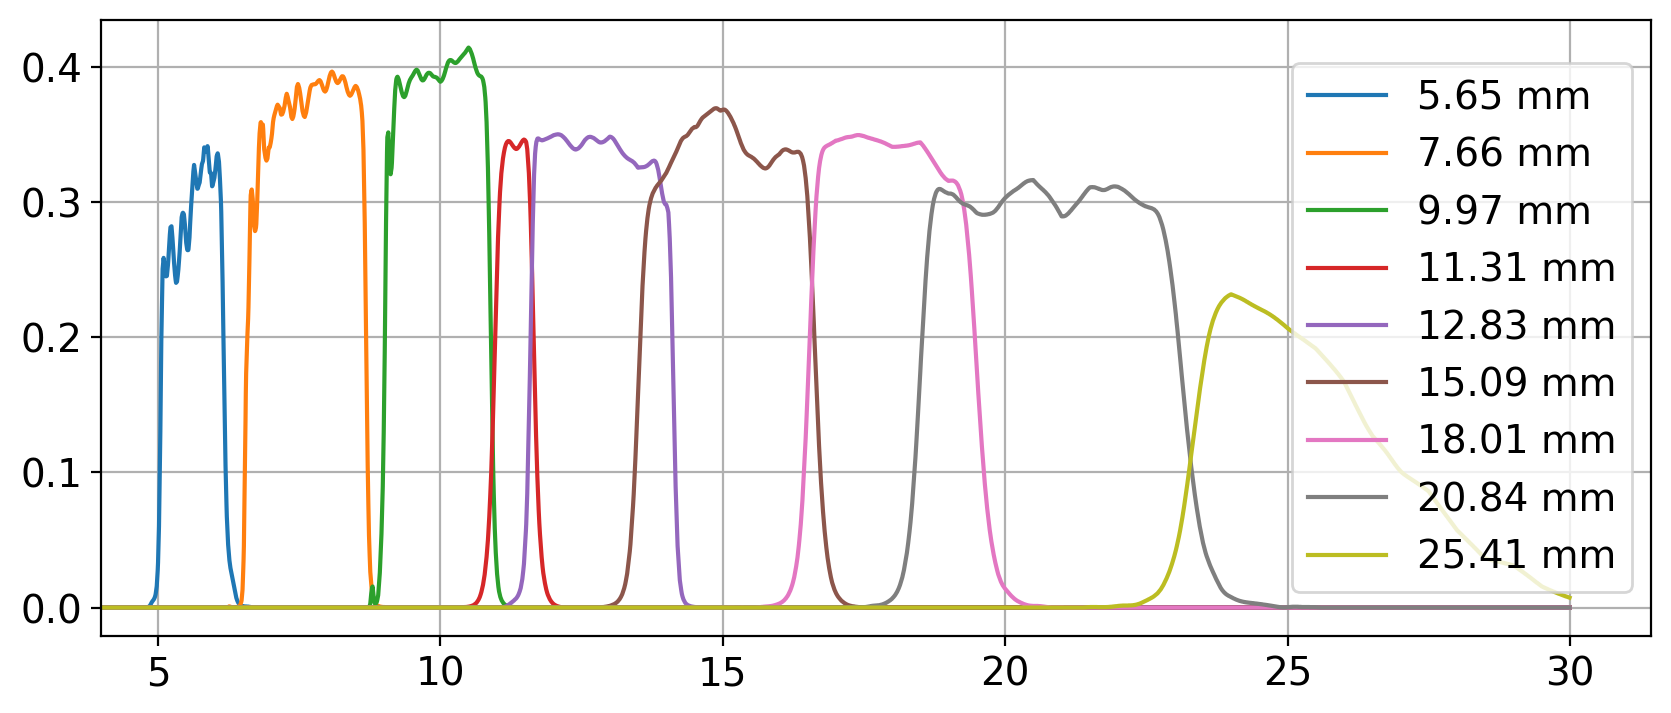

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
for fil in miri_filters:
    ax.plot(fil.wl, fil.throughput, label=f"{fil.eff_wl:.2f} mm")
ax.grid()
ax.legend(loc="right")
ax.set_xlim(left=4.0)

Filter:  F560W  Wavelength:  5.6452655486200305
Photons from star: 8.803e+10
Photons from planet: 1.789e+07
Photons from background: 1.701e+05
S/N: 53.924
------------
Filter:  F770W  Wavelength:  7.663440464232599
Photons from star: 9.196e+10
Photons from planet: 1.962e+07
Photons from background: 2.464e+06
S/N: 57.866
------------
Filter:  F1000W  Wavelength:  9.968147556199831
Photons from star: 4.207e+10
Photons from planet: 9.270e+06
Photons from background: 7.181e+06
S/N: 40.422
------------
Filter:  F1130W  Wavelength:  11.310970719752824
Photons from star: 9.994e+09
Photons from planet: 2.230e+06
Photons from background: 4.045e+06
S/N: 19.951
------------
Filter:  F1280W  Wavelength:  12.831382723049595
Photons from star: 2.424e+10
Photons from planet: 5.461e+06
Photons from background: 2.674e+07
S/N: 31.350
------------
Filter:  F1500W  Wavelength:  15.091353329686699
Photons from star: 1.917e+10
Photons from planet: 4.367e+06
Photons from background: 9.834e+07
S/N: 28.134
---

(<Figure size 1100x700 with 2 Axes>,
 <AxesSubplot:xlabel='Wavelength [$\\mu$m]', ylabel='SNR'>)

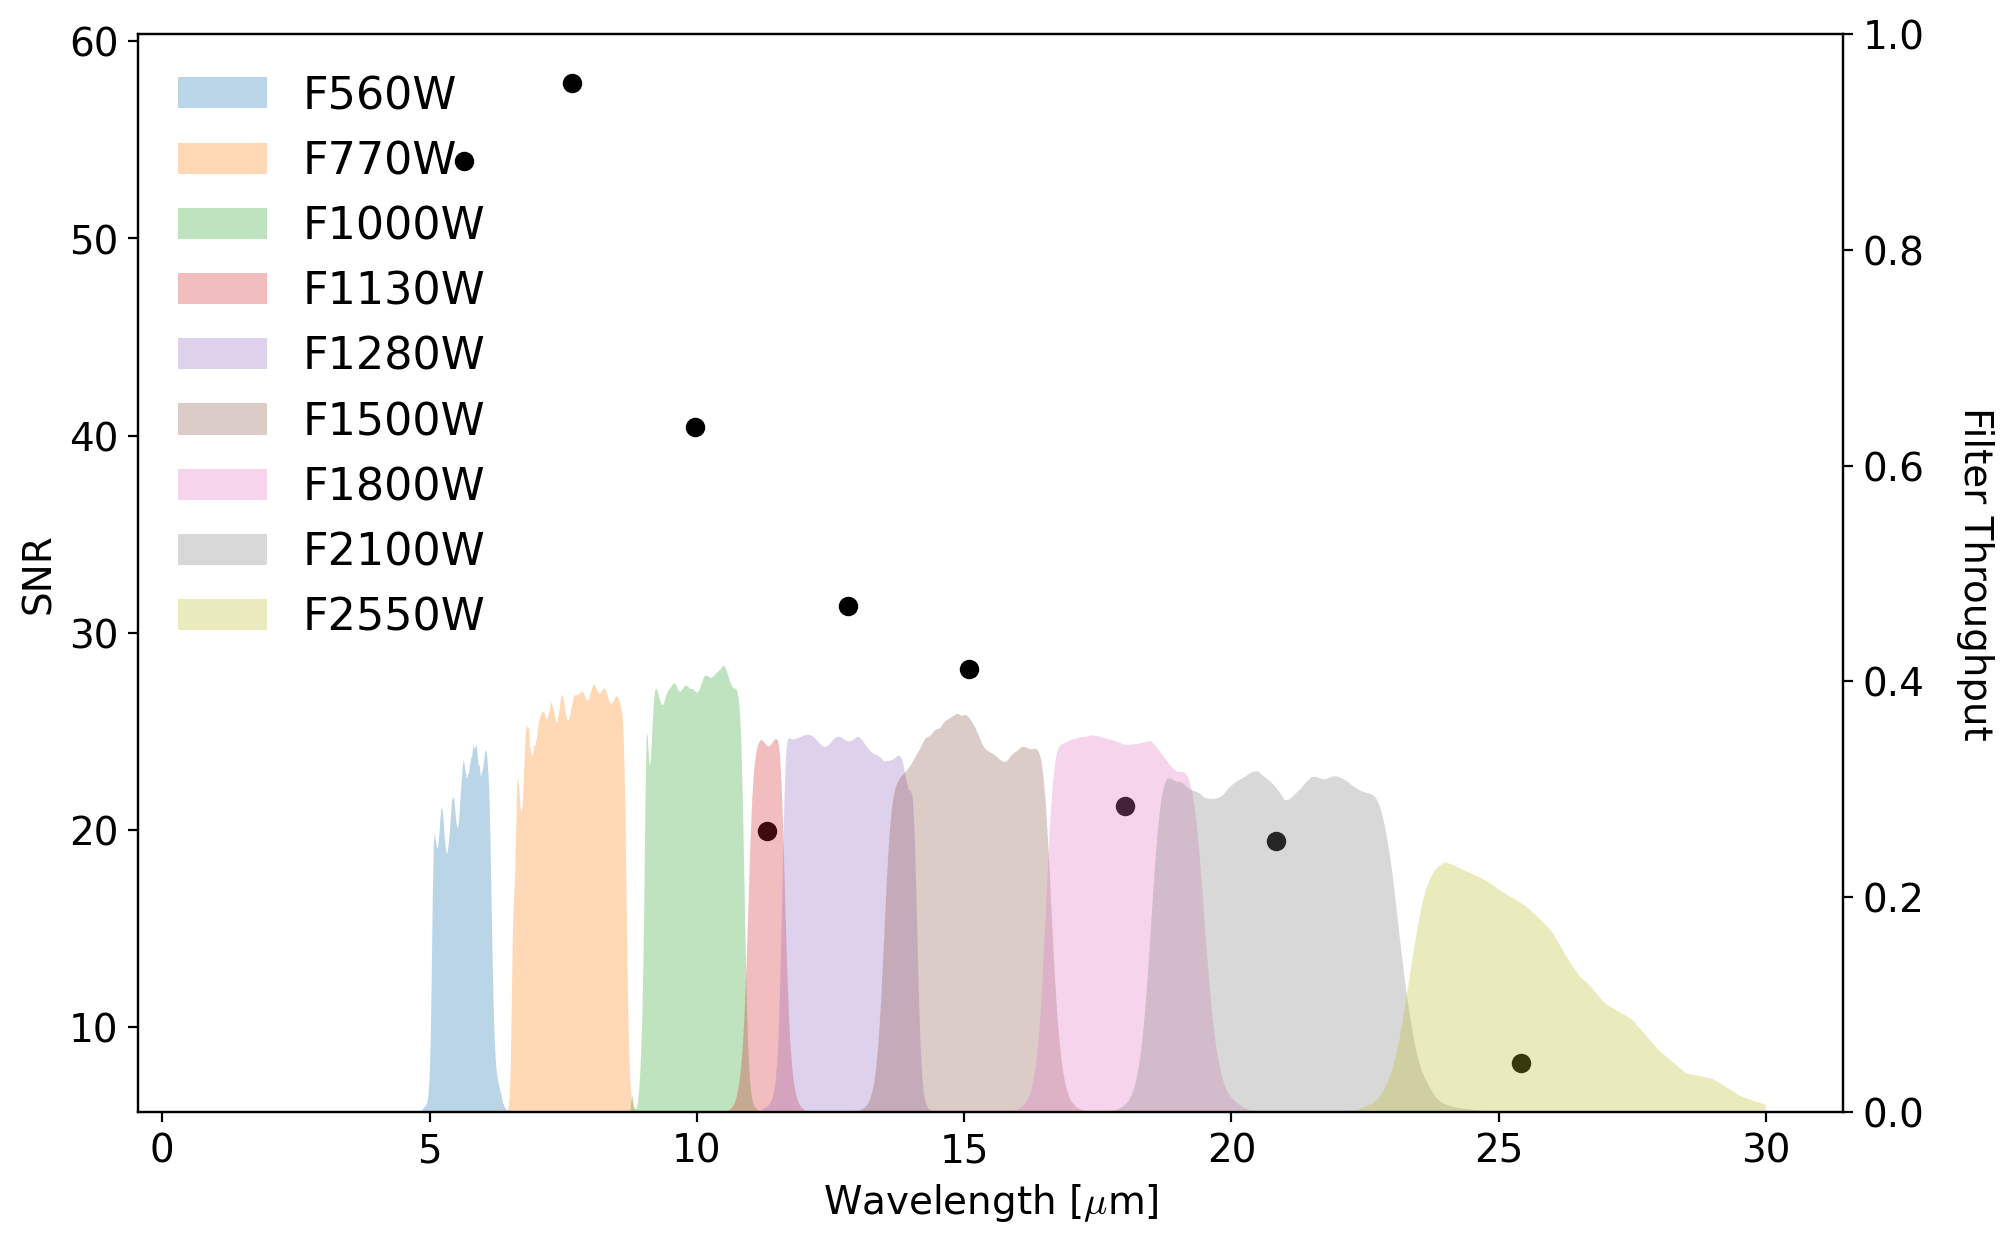

In [5]:
# 55 Cancri e
Tstar = 3233
Tplan = 2349
Rs = 0.960
Rp = 1.91
d = 12.48  # distance in pc

pp.detect.jwst.estimate_eclipse_snr(Tstar=Tstar, Tplan=Tplan, Rs=Rs, Rp=Rp, d=d)

In [6]:
lammin = 4.0
lammax = 12.0
Nlam = 400

# Generate high-res wavelength grid
lam = np.linspace(lammin, lammax, Nlam)
dlam = lam[1:] - lam[:-1]
dlam = np.hstack([dlam, dlam[-1]])

# Calculate BB intensities for the star and planet
Bstar = pp.detect.jwst.planck(Tstar, lam)  # W*sr^-1m^-2m^-1
Bplan = pp.detect.jwst.planck(Tplan, lam)

Rs = 0.960 * u.Rsun.in_units(u.m) * u.m
Rp = 0.0187 * Rs

# Monochromatic total luminosity
Ls = 4 * np.pi * 4 * np.pi * Rs ** 2 * Bstar * u.W / u.m ** 3
Lp = 4 * np.pi * 4 * np.pi * Rp ** 2 * Bplan * u.W / u.m ** 3

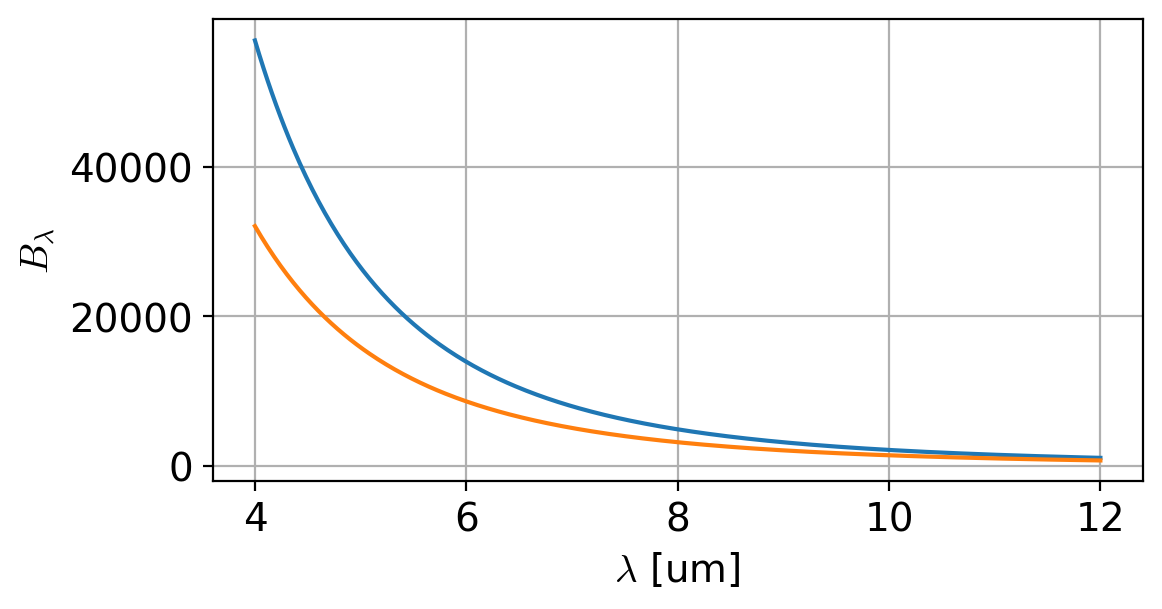

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lam, Bstar)
ax.plot(lam, Bplan)

ax.set(xlabel="$\lambda$ [um]", ylabel="$B_\lambda$")
ax.grid()

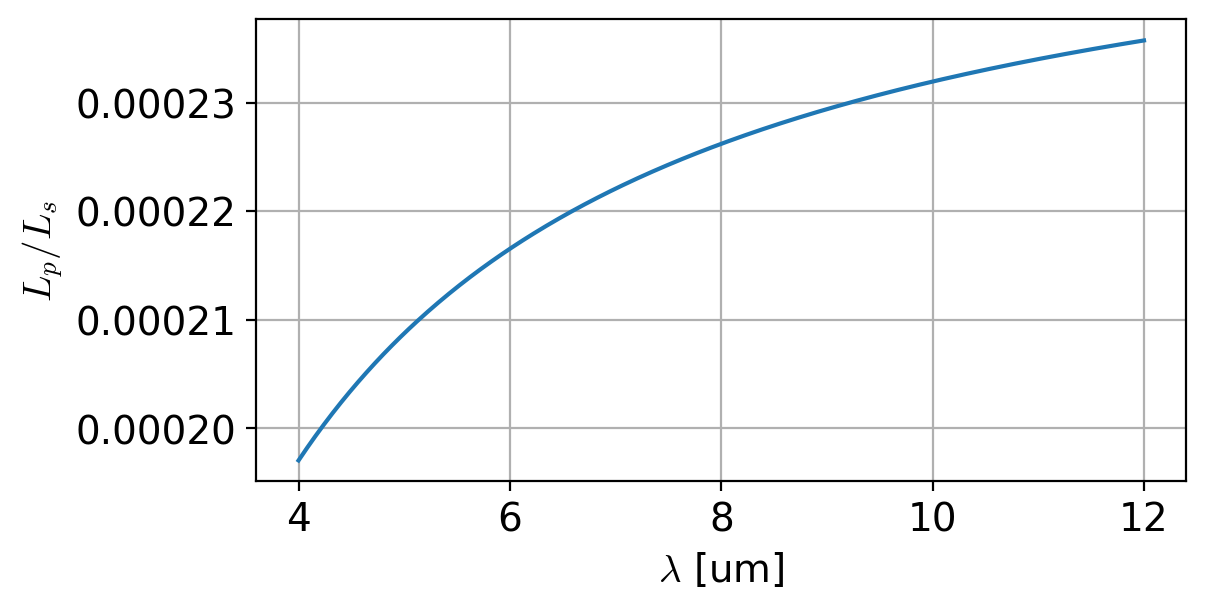

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(lam, Lp / Ls)
ax.set(xlabel="$\lambda$ [um]", ylabel="$L_p/L_s$")
ax.grid()

### Mock light curve

In [9]:
# Star map
map_star = starry.Map(ydeg=5, nw=len(Bstar))
map_star.amp = Ls

# Planet map
map_planet = starry.Map(ydeg=10, nw=len(Bplan))
map_planet.amp = Lp
map_planet[1:, :, :] = 1e-01 * np.random.rand((10 + 1) ** 2 - 1, 400)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [10]:
params_s = dict(
    ydeg=5,  # degree of the map
    nw=len(Bstar),
    udeg=2,  # degree of the limb darkening
    inc=83.3,  # inclination in degrees
    amp=map_star.amp,  # amplitude (a value prop. to luminosity)
    r=0.960,  #  radius in R_sun
    m=0.960,  # mass in M_sun
    prot=42.2,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
    y=map_star[1:, :, :],  # the spherical harmonic coefficients
)

params_p = dict(
    ydeg=10,  # degree of the map
    nw=len(Bstar),
    inc=83.3,  # inclination in degrees
    amp=map_planet.amp,  # amplitude (a value prop. to luminosity)
    r=0.0187 * 0.960,  #  radius in R_sun
    m=2.43e-05,  #  mass in M_sun
    porb=0.736539,  # orbital period in days
    prot=0.736539,  # rotational period in days
    t0=0.15,  # reference time in days (when it transits A)
    e=0.05,
    y=map_planet[1:, :, :],  # the spherical harmonic coefficients
)

star = starry.Primary(
    starry.Map(
        ydeg=params_s["ydeg"],
        nw=params_s["nw"],
        udeg=params_s["udeg"],
        inc=params_s["inc"],
        amp=params_s["amp"],
    ),
    r=params_s["r"],
    m=params_s["m"],
    prot=params_s["prot"],
)

planet = starry.Secondary(
    starry.Map(
        ydeg=params_p["ydeg"],
        nw=params_p["nw"],
        inc=params_p["inc"],
        amp=params_p["amp"],
    ),
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=params_p["inc"],
)

planet2 = starry.Secondary(
    starry.Map(
        ydeg=params_p["ydeg"],
        nw=params_p["nw"],
        inc=params_p["inc"],
        amp=params_p["amp"],
    ),
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=60.0,
)

star.map[1:] = params_s["u"]  # limb darkening
star.map[1:, :, :] = params_s["y"]
planet.map[1:, :, :] = params_p["y"]
planet2.map[1:, :, :] = params_p["y"]

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [14]:
sys = starry.System(star, planet)
sys_cont = starry.System(star, planet2) # to compute continuum flux

# 1min exposure time
t = np.linspace(-0.3, 0.3, int(0.6*24*60))
flux = sys.flux(t=t)/(4*np.pi*(d*u.pc.to(u.m))**2)
flux_cont = sys_cont.flux(t=t)/(4*np.pi*(d*u.pc.to(u.m))**2)

Compiling `X`... Done.
Compiling `X`... Done.


[Text(0.5, 0, 'time [hours]'), Text(0, 0.5, 'Flux [W/m2/m]')]

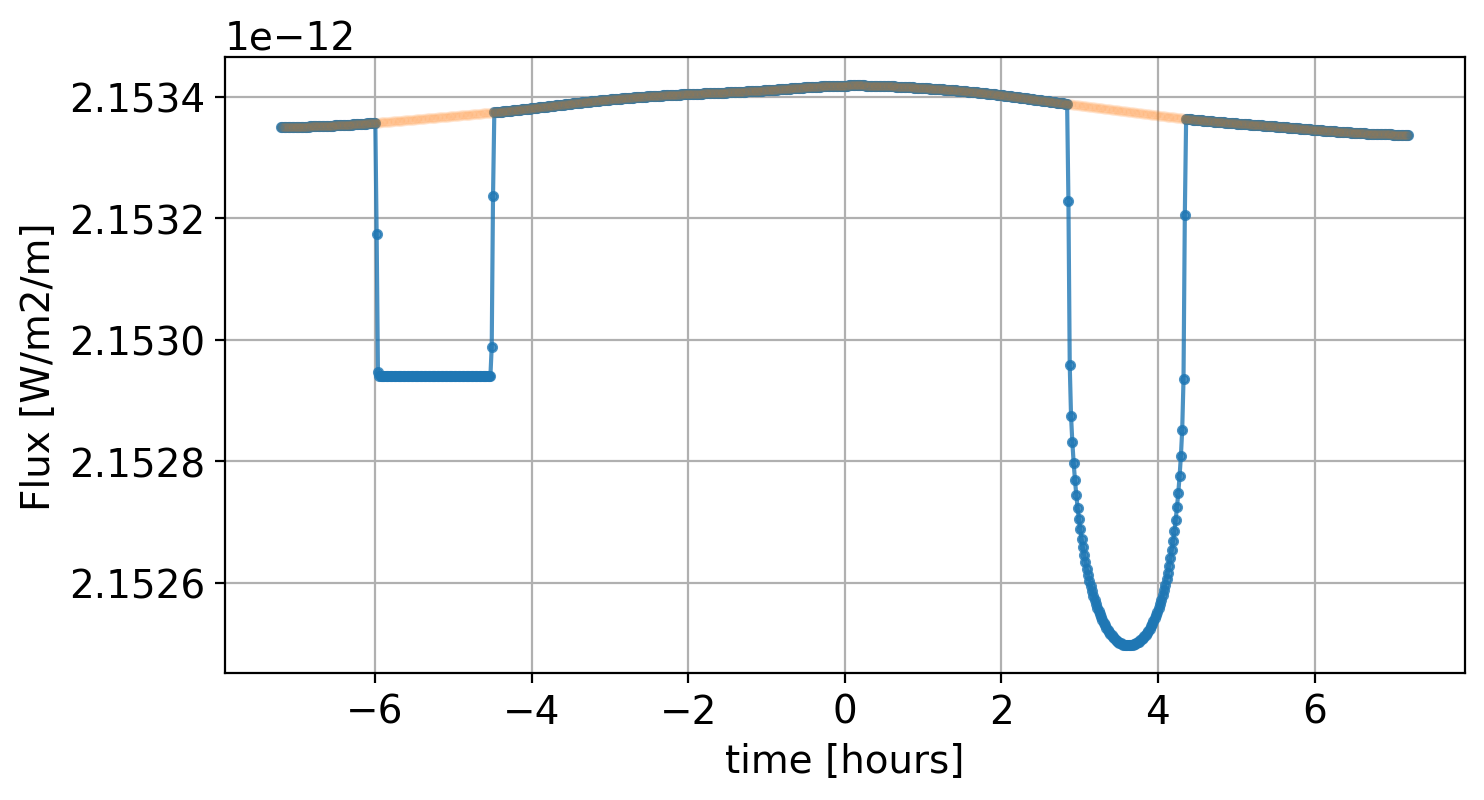

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t * 24, flux[:, 0], "C0.-", alpha=0.8)
ax.plot(t * 24, flux_cont[:, 0], "C1.-", alpha=0.05)

ax.grid()
ax.set(xlabel="time [hours]", ylabel="Flux [W/m2/m]")
# ax.set_xlim(-6.25,-5.75)

In [16]:
filt = miri_filters[1]
filt.compute_lightcurve(t, flux, flux_cont, lam)

Computing observed light curve in F560W filter...


Text(0, 0.5, 'Normalized flux')

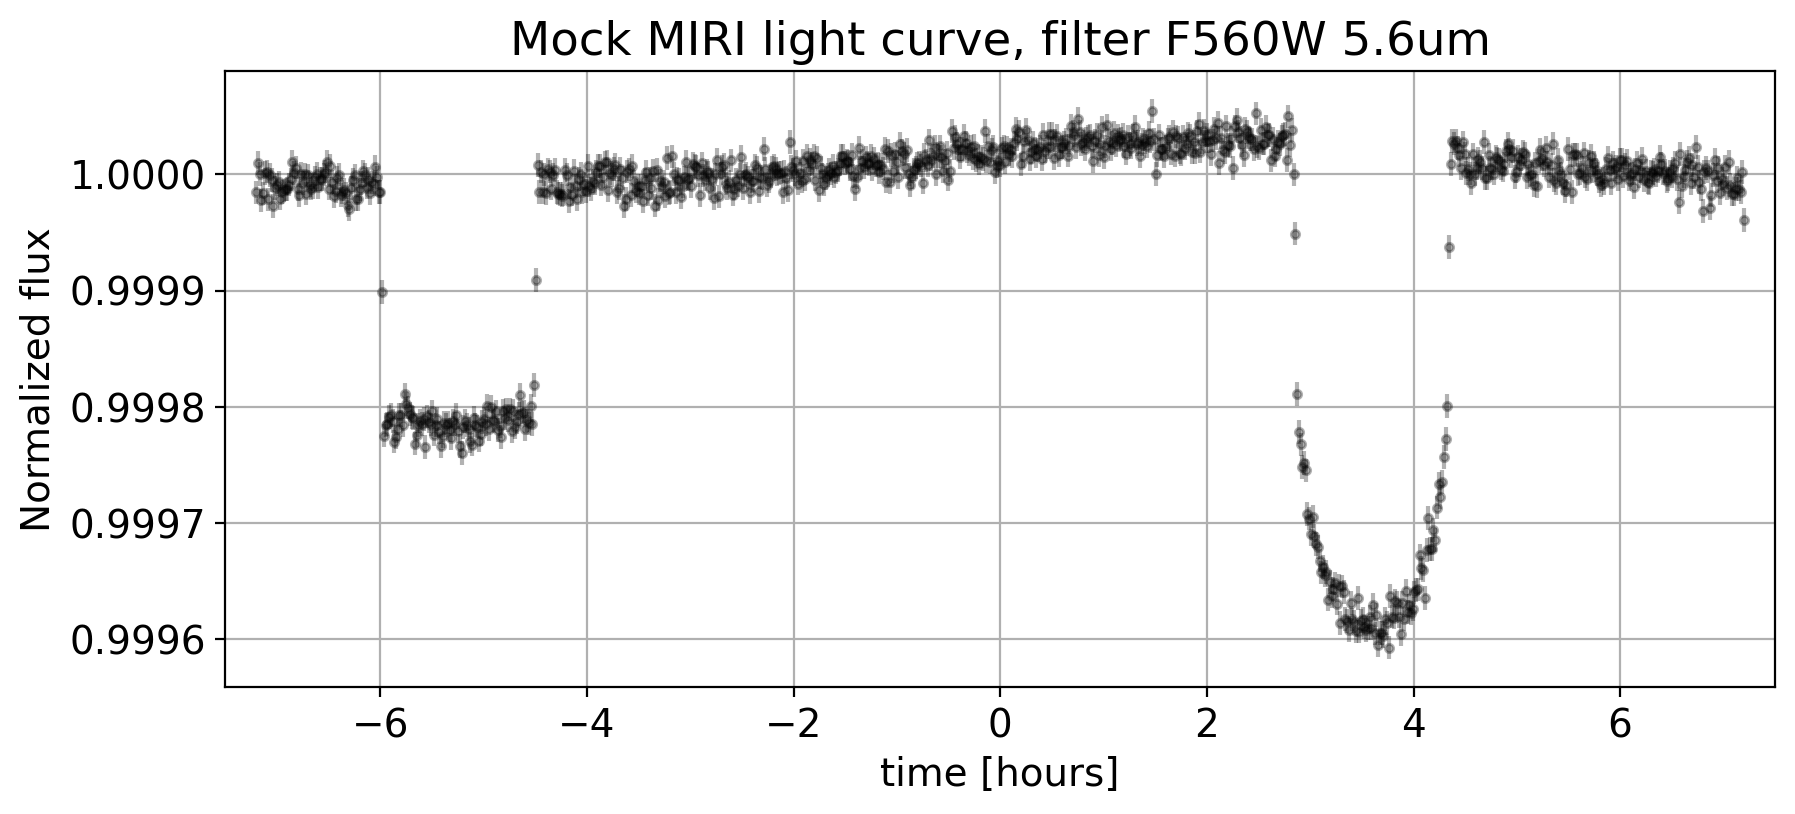

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(
    filt.lightcurve.time*24,
    filt.lightcurve.obs,
    filt.lightcurve.sig,
    fmt=".",
    color="black",
    alpha=0.3,
)
ax.grid()
ax.set_title(f"Mock MIRI light curve, filter {filt.name} {filt.eff_wl:.1f}um")
ax.set_xlabel('time [hours]')
ax.set_xlim(-7.5, 7.5)
ax.set_ylabel("Normalized flux")